https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html
https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.grid_search_forecaster

Percentual change in both score + close
scaling / no scaling
enseble methods (tree regressor)
ridge regressor (linear)
lightlgbm (gradient boosted tree enesmble) # errors in implementation
XGTrees -> Good performance but unseen close_values of issue -> Try change instead?
Change as y -> better performance
Try out classification of pos or neg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vaderSentiment
import os
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv(os.path.join(os.getcwd(),"tweet_data", "Tweet_Stocks_Sentiment.csv"), index_col="tweet_id")
symbols = ["AAPL", "AMZN", "GOOG", "GOOGL", "MSFT", "TSLA"]

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"

    return compound

def main():
    return 0
    # Create Sentiment Data
    # Create Daily Sentiment for stock
    data = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Tweet_Stocks_Sentiment.csv"), index_col="tweet_id")
    symbols = ["AAPL", "AMZN", "GOOG", "GOOGL", "MSFT", "TSLA"]
    date_score = pd.DataFrame()
    date_score.index = data.post_date.unique()
    for s in symbols:
        group = data[data[s] > 0]
        avg = group.groupby('post_date')["score"].mean().rename(s)
        date_score = date_score.join(avg, lsuffix="")

    #create avergae
    date_score["avg_score"] = date_score.sum(axis=1) / 6
    # Save to disk
    date_score.to_csv(os.path.join(os.getcwd(), "tweet_data", "Daily_Sentiment.csv"))


def create_sentiment_scores():
    data = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Tweet.csv"), index_col="tweet_id")
    data["post_date"] = pd.to_datetime(data["post_date"], unit="s")
    symbol = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Company_Tweet.csv"), index_col="tweet_id")
    s = pd.get_dummies(symbol, prefix_sep="", prefix="").max(level=0)
    data = data.join(s)
    data = data.reset_index()
    scores = [sentiment_vader(t) for t in tqdm.tqdm(data["body"])]
    data["score"] = scores
    data.to_csv(os.path.join(os.getcwd(), "tweet_data", "Tweet_Stocks_Sentiment.csv"))

def create_daily_sentiment():
    data = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Tweet_Stocks_Sentiment.csv"), index_col="tweet_id")
    symbols = ["AAPL", "AMZN", "GOOG", "GOOGL", "MSFT", "TSLA"]
    date_score = pd.DataFrame()
    date_score.index = data.post_date.unique()
    for s in symbols:
        group = data[data[s] > 0]
        avg = group.groupby('post_date')["score"].mean()
        date_score = date_score.join(avg, lsuffix=s)

    date_score.score = np.sum(date_score[:, :-1])
    # create average:
    date_score.score = (date_score.sum(axis=1) - date_score.score) / 5
    # Save to disk
    date_score.to_csv(os.path.join(os.getcwd(), "tweet_data", "Daily_Sentiment.csv"))


def compare_sentiment_to_avg(data, symbols = ["AAPL"], save=False, path="SentimentComp.png"):
    plt.plot(data[symbols + ["avg_score"]].resample("1m").mean())
    plt.legend(symbols + ["Average"])
    plt.suptitle("Monthly Sentiment by Stock")
    plt.title("Sentiment between very negativ (-1) and very positiv (+1)")
    plt.xlabel("Date")
    plt.ylabel("Sentiment")
    if save:
        plt.savefig(path)
    plt.show()

def prepare_stock_data():
    stocks = pd.read_csv(os.path.join(os.getcwd(), "stock_data", "Stocks.csv"), index_col=["day_date", "ticker_symbol"])
    stocks.index = stocks.index.set_levels([pd.to_datetime(stocks.index.levels[0]), stocks.index.levels[1]])
    return stocks

def align_stock_sentiment(stock_data,sentiment_data, symbol = "AAPL", start = "2015-01-01", end = "2019-12-31"):
    if symbol not in sentiment_data.columns:
        raise KeyError(f"{symbol} not in data.")
    s = stock_data.copy(deep=True)
    s = s.loc[pd.IndexSlice[start:end,symbol],:]
    t = sentiment_data.copy(deep=True)
    t = t.loc[start:end][symbol]
    s = s.join(t)
    s["change"] = s.close_value.pct_change()
    s["change"][0] = 0
    s = s.reset_index()
    s.index = s["day_date"]
    s = s.drop(["ticker_symbol", "day_date"], axis=1)
    return s

def show_stock_sentiment(data, symbol,save = False, path = "Stock_Sentiment.png"):
    plt.plot(data.index, data["change"], c = "r")

    plt.ylabel("Close Price Difference (%)")
    plt.legend(["% Change"])

    plt.twinx()
    plt.plot(data.index,data[symbol])
    plt.ylabel("Average Sentiment Score")
    plt.xlabel("Days")
    plt.suptitle("Stock Price Change vs Sentiment")
    plt.title(f"From {data.index.min().date()} to {data.index.max().date()} for symbol {symbol}")

    plt.legend(["Sentiment"])
    if save:
        plt.savefig(path)
    else:
        plt.show()

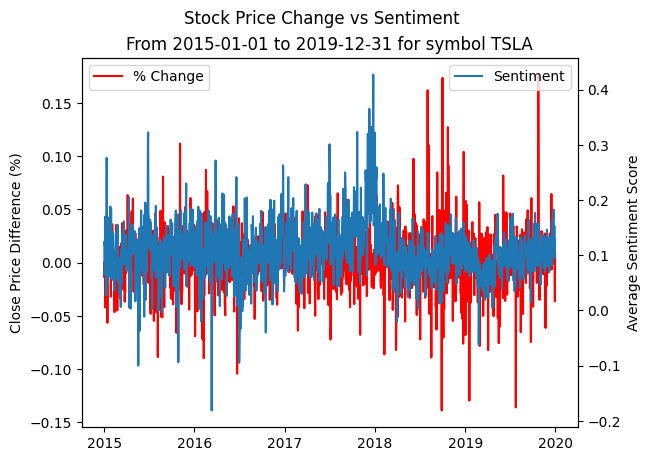

In [3]:
#CONFIG
SYMBOL = "TSLA"
START = "2015-01-01"
END = "2019-12-31"



sentiment = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Daily_Sentiment.csv"), index_col="day_date")
sentiment.index = pd.to_datetime(sentiment.index)
#compare_sentiment_to_avg(sentiment, symbols= ["AAPL", "GOOG"])
stocks = prepare_stock_data()

data = align_stock_sentiment(stocks, sentiment, symbol= SYMBOL, start=START,end=END)
show_stock_sentiment(data, SYMBOL, False)

In [4]:
#create score momentum
def score_momentum(df, symbol, intervals = ("3d", "1w")):
    s = df.copy()
    for i in intervals:
        s[f"{i}_momentum"] = s[symbol].resample(i).mean()
        s[f"{i}_momentum"].iloc[0] = s[symbol].iloc[0]
        s[f"{i}_momentum"].interpolate(inplace=True)

    return s


In [5]:
def create_split_data(data, symbol, columns, start = None, end = None, train = 0.8, return_weekdays = True):
    if start is None:
        start = data.index.min()
    if end is None:
        end = data.index.max()
    s = data.loc[start:end][columns + [symbol]].copy()
    if return_weekdays:
        t = pd.get_dummies(s.index.weekday,"week_day")
        t.index = s.index
        s = s.join(t)
    s = s.asfreq("D")
    split = int(np.floor(len(s)*train))
    val = split + int(np.floor((len(s) - split) / 3))
    return s.iloc[:split], s.iloc[split:val],s.iloc[val:]



Close Value vs. sentiment score

In [6]:
#CONFIG
SYMBOL = "TSLA"
START = "2015-01-01"
END = "2019-12-31"
COLUMNS = ["change"]
TRAIN = 0.8
EXO = False

sentiment = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Daily_Sentiment.csv"), index_col="day_date")
sentiment.index = pd.to_datetime(sentiment.index)
#compare_sentiment_to_avg(sentiment, symbols= ["AAPL", "GOOG"])
stocks = prepare_stock_data()

data = align_stock_sentiment(stocks, sentiment, symbol= SYMBOL, start=START,end=END)
data_train, data_val, data_test = create_split_data(data, SYMBOL, COLUMNS, start = START, end = END, train=TRAIN, return_weekdays=EXO)


In [7]:
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Train dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2015-01-01 00:00:00 --- 2018-12-30 00:00:00  (n=1460)
Train dates : 2018-12-31 00:00:00 --- 2019-05-01 00:00:00  (n=122)
Test dates  : 2019-05-02 00:00:00 --- 2019-12-31 00:00:00  (n=244)


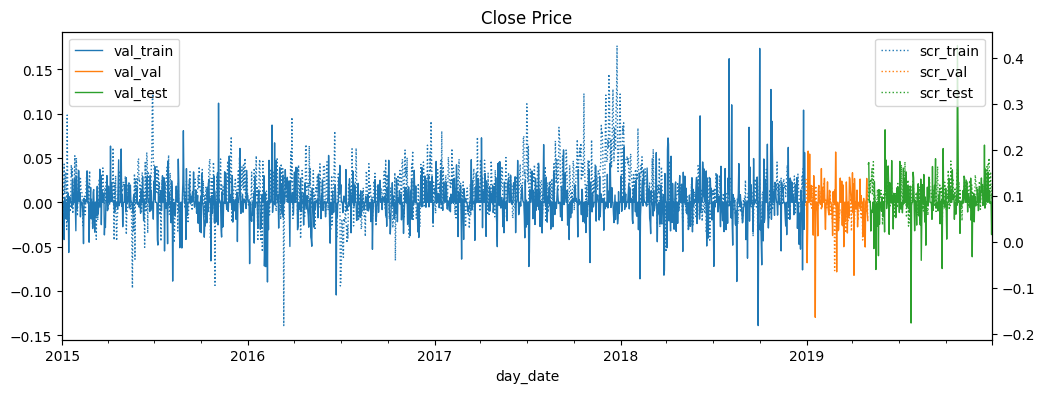

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
data_train[COLUMNS[0]].plot(ax=ax, label='val_train', linewidth=1)
data_val[COLUMNS[0]].plot(ax=ax, label='val_val', linewidth=1)
data_test[COLUMNS[0]].plot(ax=ax, label='val_test', linewidth=1)
ax.set_title('Close Price')
ax.legend()
ax2 = ax.twinx()
data_train[SYMBOL].plot(ax=ax2, label='scr_train', linewidth=1, ls =":")
data_val[SYMBOL].plot(ax=ax2, label='scr_val', linewidth=1, ls =":")
data_test[SYMBOL].plot(ax=ax2, label='scr_test', linewidth=1, ls =":")
ax2.legend()
plt.show()

In [9]:
# Create and train forecaster
# ==============================================================================
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor     = XGBRegressor(random_state=123),
                 lags          = 7,
                 transformer_y = None
             )
forecaster


ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training r

In [10]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]]]), # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 1,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = len(data_train), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )


Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:32<00:00, 23.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.0007707515725903267



In [11]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]],data_test[COLUMNS[0]]]),
    initial_train_size = len(data_train)+ len(data_val),
    fixed_train_size   = False,
    steps      = 1,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 0.000817786013540443


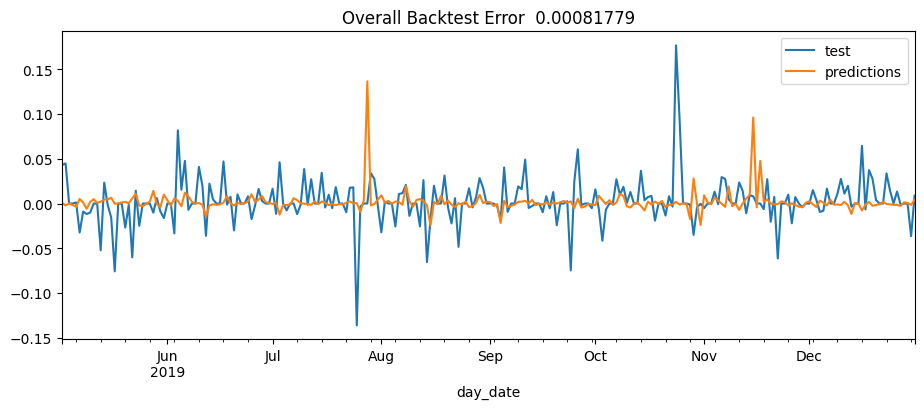

In [12]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test[COLUMNS[0]].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.set_title(f"Overall Backtest Error  {np.round(metric,8)}")
ax.legend()

In [13]:
forecaster.get_feature_importance().sort_values(by="importance",ascending=False)

,feature,importance
7,lag_8,0.057752
15,lag_16,0.054724
20,lag_21,0.054342
8,lag_9,0.053468
16,lag_17,0.052907
5,lag_6,0.052009
22,lag_23,0.051690
19,lag_20,0.047488
10,lag_11,0.046504
13,lag_14,0.046163


Close vs Change + Volume + weekday

In [14]:
#CONFIG
COLUMNS = ["change", "volume"]
TRAIN = 0.8
EXO = True

data_train, data_val, data_test = create_split_data(data, SYMBOL, COLUMNS, train=TRAIN, return_weekdays=EXO)
data_train

,change,volume,TSLA,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
day_date,,,,,,,,,,
2015-01-01,0.000000,2392947,0.119240,0,0,0,1,0,0,0
2015-01-02,-0.013938,4753239,0.124399,0,0,0,0,1,0,0
2015-01-03,0.000000,4753239,0.064440,0,0,0,0,0,1,0
2015-01-04,0.000000,4753239,0.108081,0,0,0,0,0,0,1
2015-01-05,-0.042041,5355485,0.169627,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-26,0.103930,8143102,0.144886,0,0,1,0,0,0,0
2018-12-27,-0.030544,8567385,0.083979,0,0,0,1,0,0,0
2018-12-28,0.056116,9918777,0.139225,0,0,0,0,1,0,0


In [15]:
from sklearn.preprocessing import StandardScaler

# Create and train forecaster
# ==============================================================================
exog = [column for column in data_train.columns if column.startswith('week')]


# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor     = XGBRegressor(random_state=123),
                 lags          = 7,

                 transformer_y = StandardScaler()
             )
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None

In [16]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]]]), # Train and validation data
        exog               = pd.concat([data_train[exog],data_val[exog]]),
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 1,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = len(data_train), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [02:36<00:00, 39.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.0007291760658806887



In [17]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]],data_test[COLUMNS[0]]]),
    initial_train_size = len(data_train)+ len(data_val),
    fixed_train_size   = False,
    steps      = 1,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 0.0007508259352217139


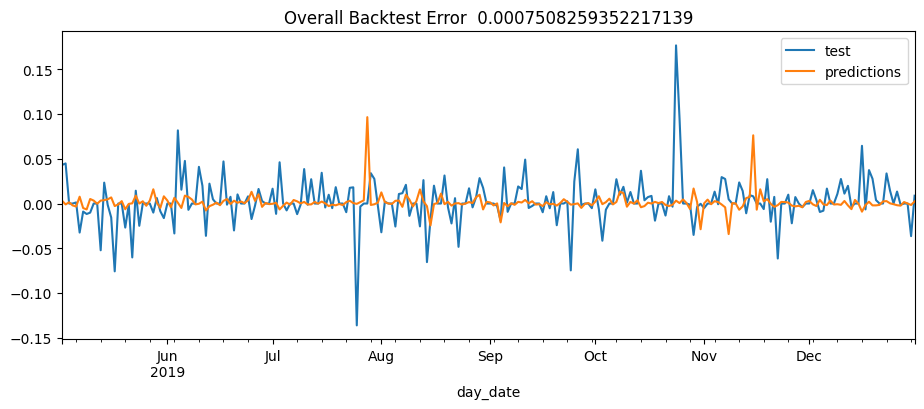

In [18]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test[COLUMNS[0]].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.set_title(f"Overall Backtest Error  {metric}")
ax.legend()

In [19]:
forecaster.get_feature_importance().sort_values(by="importance",ascending=False)

,feature,importance
2,lag_3,0.060438
15,lag_16,0.059581
21,lag_22,0.048790
22,lag_23,0.048573
14,lag_15,0.047757
20,lag_21,0.044910
5,lag_6,0.043302
19,lag_20,0.042923
6,lag_7,0.042021
1,lag_2,0.041351


Classification

In [20]:
#CONFIG
COLUMNS = ["change", "volume"]
TRAIN = 0.8
EXO = True
bins = [-np.inf, 0, np.inf]
labels = [0,1]
classLabel = ["Negative", "Neutral", "Positive"]
temp = data.copy()
temp["change"] = pd.cut(temp["change"],bins, labels=labels)
data_train, data_val, data_test = create_split_data(temp, SYMBOL, COLUMNS, train=TRAIN, return_weekdays=EXO)



Train dates : 2015-01-01 00:00:00 --- 2018-12-30 00:00:00  (n=1460)
Train dates : 2018-12-31 00:00:00 --- 2019-05-01 00:00:00  (n=122)
Test dates  : 2019-05-02 00:00:00 --- 2019-12-31 00:00:00  (n=244)


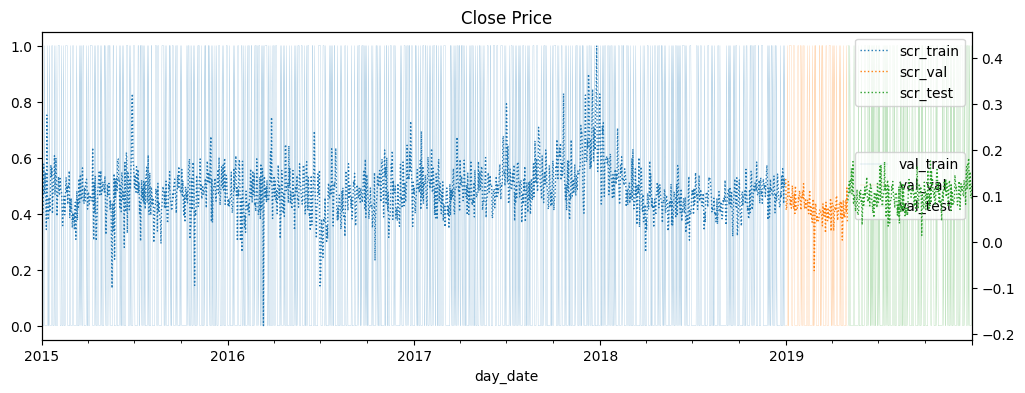

In [21]:
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Train dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
fig, ax = plt.subplots(figsize=(12, 4))
data_train[COLUMNS[0]].astype(int).plot(ax=ax, label='val_train', linewidth=0.1)
data_val[COLUMNS[0]].astype(int).plot(ax=ax, label='val_val', linewidth=0.1)
data_test[COLUMNS[0]].astype(int).plot(ax=ax, label='val_test', linewidth=0.1)
ax.set_title('Close Price')
ax.legend()
ax2 = ax.twinx()
data_train[SYMBOL].plot(ax=ax2, label='scr_train', linewidth=1, ls =":")
data_val[SYMBOL].plot(ax=ax2, label='scr_val', linewidth=1, ls =":")
data_test[SYMBOL].plot(ax=ax2, label='scr_test', linewidth=1, ls =":")
ax2.legend()
plt.show()

In [22]:
from xgboost import XGBClassifier
# Create and train forecaster
# ==============================================================================
exog = [column for column in data_train.columns if column.startswith('week')]


# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor     = XGBClassifier(random_state=123),
                 lags          = 7,
                 transformer_y = None
             )
forecaster

ForecasterAutoreg 
Regressor: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 

In [26]:
from sklearn.metrics import accuracy_score
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3,5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]]]), # Train and validation data
        exog               = pd.concat([data_train[exog],data_val[exog]]),
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 1,
        refit              = False,
        metric             = accuracy_score,
        initial_train_size = len(data_train), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

Number of models compared: 48.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [02:22<00:00, 35.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.5491803278688525



In [27]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]],data_test[COLUMNS[0]]]),
    initial_train_size = len(data_train)+ len(data_val),
    fixed_train_size   = False,
    steps      = 1,
    refit      = False,
    metric     = accuracy_score,
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest Error: {1-metric}")

Backtest Error: 0.35655737704918034


In [ ]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test[COLUMNS[0]].astype(int).plot(ax=ax, label='test')
predictions['pred'].astype(int).plot(ax=ax, label='predictions')
ax.set_title(f"Overall Backtest Error  {1-np.round(metric,2)}")
ax.legend()

In [ ]:
forecaster.get_feature_importance().sort_values(by="importance",ascending=False)

Momentum Regression

In [ ]:
#CONFIG
SYMBOL = "TSLA"
START = "2015-01-01"
END = "2019-12-31"
COLUMNS = ["change", "3d_momentum","1w_momentum"]
TRAIN = 0.8
EXO = True

sentiment = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Daily_Sentiment.csv"), index_col="day_date")
sentiment.index = pd.to_datetime(sentiment.index)
#compare_sentiment_to_avg(sentiment, symbols= ["AAPL", "GOOG"])
stocks = prepare_stock_data()

data = align_stock_sentiment(stocks, sentiment, symbol= SYMBOL, start=START,end=END)
data = score_momentum(data,SYMBOL)
data_train, data_val, data_test = create_split_data(data, SYMBOL, COLUMNS, start = START, end = END, train=TRAIN, return_weekdays=EXO)


In [ ]:
# Create and train forecaster
# ==============================================================================
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor     = XGBRegressor(random_state=123),
                 lags          = 7,
                 transformer_y = None
             )
forecaster

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]]]), # Train and validation data
        exog               = pd.concat([data_train[exog],data_val[exog]]),
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 1,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = len(data_train), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = False
        )

In [ ]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = pd.concat([data_train[COLUMNS[0]],data_val[COLUMNS[0]],data_test[COLUMNS[0]]]),
    initial_train_size = len(data_train)+ len(data_val),
    fixed_train_size   = False,
    steps      = 1,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

In [ ]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test[COLUMNS[0]].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.set_title(f"Overall Backtest Error {metric}")
ax.legend()

In [ ]:
forecaster.get_feature_importance().sort_values(by="importance",ascending=False)

In [ ]:
def create_train_forecaster(symbol, start, end, exog, task, columns, target,steps = 1, verbose = False):
    #CONFIG
    SYMBOL = symbol
    START = start
    END = end
    COLUMNS = [target] + columns
    TRAIN = 0.8
    EXO = exog

    sentiment = pd.read_csv(os.path.join(os.getcwd(), "tweet_data", "Daily_Sentiment.csv"), index_col="day_date")
    sentiment.index = pd.to_datetime(sentiment.index)
    #compare_sentiment_to_avg(sentiment, symbols= ["AAPL", "GOOG"])
    stocks = prepare_stock_data()

    data = align_stock_sentiment(stocks, sentiment, symbol= SYMBOL, start=START,end=END)
    #data = score_momentum(data,SYMBOL)
    if task == "regression":
        data_train, data_val, data_test = create_split_data(data, SYMBOL, COLUMNS, start = START, end = END, train=TRAIN, return_weekdays=EXO)
    elif task == "classification":
        bins = [-np.inf, 0, np.inf]
        labels = [0,1]
        temp = data.copy()
        temp["change"] = pd.cut(temp["change"],bins, labels=labels)
        data_train, data_val, data_test = create_split_data(temp, SYMBOL, COLUMNS, start = START, end = END, train=TRAIN, return_weekdays=EXO)
    else:
        raise ValueError(f"{task} is not in set (regression, classificatiom")




    if task == "regression":
        regressor = XGBRegressor(random_state=123)
        scaler = StandardScaler()
    elif task == "classification":
        regressor = XGBClassifier(random_state=123)
        scaler = None
    else:
        raise ValueError(f"{task} is not in set (regression, classification")
    # Create and train forecaster
    # ==============================================================================
    # Create forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = regressor,
                     lags          = 7,
                     transformer_y = scaler
                 )
    if verbose:
        print(forecaster)

    param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }

    # Lags used as predictors
    lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]
    if exog:
        exog = [column for column in data_train.columns if column.startswith('week')]
        exog = pd.concat([data_train[exog],data_val[exog]])
    else:
        exog = None

    results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = pd.concat([data_train[target],data_val[target]]), # Train and validation data
        exog               = exog,
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = steps,
        refit              = False,
        metric             = 'mean_squared_error' if task == "regression" else accuracy_score,
        initial_train_size = len(data_train), # Model is trained with trainign data
        fixed_train_size   = False,
        return_best        = True,
        verbose            = verbose
        )
    print(results_grid)
    metric, predictions = backtesting_forecaster(
        forecaster = forecaster,
        y          = pd.concat([data_train[target],data_val[target],data_test[target]]),
        initial_train_size = len(data_train)+ len(data_val),
        fixed_train_size   = False,
        steps      = steps,
        refit      = False,
        metric     = 'mean_squared_error' if task == "regression" else accuracy_score,
        verbose    = verbose # Change to True to see detailed information
    )

    print(f"Backtest error: {metric}")
    # Plot of predictions
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(11, 4))
    if task == "regression":
        data_test[COLUMNS[0]].plot(ax=ax, label='test')
        predictions['pred'].plot(ax=ax, label='predictions')

    elif task == "classification":
        data_test[COLUMNS[0]].astype(int).plot(ax=ax, label='test')
        predictions['pred'].astype(int).plot(ax=ax, label='predictions')
    ax.set_title(f"Overall Backtest Metric {metric}")
    ax.legend()
    plt.savefig(f"{symbol}_{task}")
    plt.show()



In [ ]:
create_train_forecaster("GOOG","2015-01-01", "2018-12-31", exog= True,task="classification", columns=["volume"], target="change", steps=1, verbose=False)
#%
%

In [35]:
data_train


,change,volume,TSLA,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
day_date,,,,,,,,,,
2015-01-01,0,2392947,0.119240,0,0,0,1,0,0,0
2015-01-02,0,4753239,0.124399,0,0,0,0,1,0,0
2015-01-03,0,4753239,0.064440,0,0,0,0,0,1,0
2015-01-04,0,4753239,0.108081,0,0,0,0,0,0,1
2015-01-05,0,5355485,0.169627,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-26,1,8143102,0.144886,0,0,1,0,0,0,0
2018-12-27,0,8567385,0.083979,0,0,0,1,0,0,0
2018-12-28,1,9918777,0.139225,0,0,0,0,1,0,0


In [75]:
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader

SEQUENCE_LENGTH = 30
BATCH_SIZE = 4

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

split = int(len(data) / 10)
train_data = data[:-split]
test_data = data[-split:]
train_data = train_data.reset_index()

train_dataset = SequenceDataset(
    train_data,
    target="close_value",
    features=["close_value","TSLA"],
    sequence_length=SEQUENCE_LENGTH
)
test_dataset = SequenceDataset(
    test_data,
    target="close_value",
    features=["close_value","TSLA"],
    sequence_length=SEQUENCE_LENGTH
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, features, hidden_units):
        super().__init__()
        self.features = features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [73]:
train_data

,day_date,close_value,volume,open_value,high_value,low_value,TSLA,change
0,2015-01-01,222.41,2392947,223.09,225.6800,222.2500,0.119240,0.000000
1,2015-01-02,219.31,4753239,222.87,223.2500,213.2600,0.124399,-0.013938
2,2015-01-03,219.31,4753239,222.87,223.2500,213.2600,0.064440,0.000000
3,2015-01-04,219.31,4753239,222.87,223.2500,213.2600,0.108081,0.000000
4,2015-01-05,210.09,5355485,214.55,216.5000,207.1626,0.169627,-0.042041
...,...,...,...,...,...,...,...,...
1639,2019-06-28,223.46,6851384,220.99,225.1700,220.8000,0.075020,0.002782
1640,2019-06-29,223.46,6851384,220.99,225.1700,220.8000,0.127617,0.000000
1641,2019-06-30,223.46,6851384,220.99,225.1700,220.8000,0.103639,0.000000
1642,2019-07-01,227.17,8237964,230.21,233.0995,226.2800,0.086247,0.016603


In [78]:
learning_rate = 5e-5
num_hidden_units = 32

model = ShallowRegressionLSTM(features=2, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()